### Imports

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt

### Need for Positional Encodings

In [ ]:
# Loading a trained model from hugging face
model_id = "Qwen/Qwen3-0.6B"
tok = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id)

# Using a sample text, we tokenize it and embed using the above loaded model
text = "The bank beside the river bank"

# Tokenizing text
tokens = tok(text, return_tensors='pt')['input_ids']
print(f"Tokenized text: {tokens.tolist()}, Shape: {tokens.shape}")

# Generating the text embeddings
embeddings = model.embed_tokens(tokens) # in the model printed above, embed_tokens is the embedding layer
print(f"Embeddings: {embeddings}, Shape: {embeddings.shape}")

In [ ]:
# Each embedding is of dimension 1026
# We now pass this embedding through a multihead attention layer and check the output

# Embedding dimension
embedding_dim = embeddings.shape[-1]

# Inititalizing weights for queries, keys and values and the multihead attention layer 
W_q = nn.Linear(embedding_dim, embedding_dim, bias=False)
W_k = nn.Linear(embedding_dim, embedding_dim, bias=False)
W_v = nn.Linear(embedding_dim, embedding_dim, bias=False)
mha = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=4, batch_first=True)

# Initialize weights for the Multihead attention layer
with torch.no_grad():
    for param in mha.parameters():
        nn.init.normal_(param, std=0.1)

# Passing the embedding (without any positional information) through the MHA layer
output, _ = mha(W_q(embeddings), W_k(embeddings), W_v(embeddings))
print(f"Outputs: {output}, Shape: {output.shape}")

# Checking the embeddings of the second word "bank" and the last word "bank"
second_bank = output[0, 1, :]
last_bank = output[0, -1, :]

# Print if the two words have the same embeddings
print(torch.all(second_bank == last_bank).item())

### Helper functions

In [2]:
# Generate encodings for multiple positions
def generate_encodings(num_positions, dimensions, enc_type): # enc_type can be binary or sin for now
    encodings = []
    for i in range(0, num_positions):
        if enc_type == 'binary':
            enc = get_binary_encoding(position=i, dimension=dimensions)
        elif enc_type == 'sin':
            enc = get_sinusoidal_encodings(position=i, dmodel=dimensions)
        encodings.append(enc)
    return np.array(encodings)

# Plotting different indices to check the oscillation
def plot_encoding_indices(encodings, index, enc_type): # enc_type can be binary or sin for now
    plt.figure(figsize=(15, 5))
    index_values = encodings[:, index]
    if enc_type == 'binary':
        plt.step(range(len(index_values)), index_values)
    elif enc_type == 'sin':
        plt.plot(range(len(index_values)), index_values)
    plt.ylabel("Encoding values")
    plt.xlabel("Indices")
    if index == -1:
        plt.title(f"Encoding values for the last index (LSB)")
    elif index == 0:
        plt.title(f"Encoding values for the first index (MSB)")
    else:
        plt.title(f"Encoding values for the {index} index")
    plt.xticks(ticks=range(0, len(index_values), 2))
    plt.yticks(ticks=[0, 1])
    plt.show()

### Binary Positional Encodings

In [3]:
# Function to convert a position to its binary vector strecthed to match the embedding dimension
def get_binary_encoding(position, dimension):
    binary = []
    while position > 0:
        binary.append(position%2)
        position = position // 2
    padding_length = dimension - len(binary)
    binary = binary + [0]*padding_length
    return binary[::-1]

# Get integer value from a binary number
def get_integer_value(binary_number):
    binary_number = binary_number[::-1]
    return sum([number * 2**i for i, number in enumerate(binary_number)])

In [4]:
# Checking for a sample input
position, dimension = 5, 10

output = get_binary_encoding(position, dimension)
assert len(output) == dimension, "Length of the embedding vector should match the embedding dimension"
assert get_integer_value(output) == position, "Binary conversion is wrong"
print(f"Binary representation of {position} stretched to matched the embedding dimension {dimension } -> {output}")

Binary representation of 5 stretched to matched the embedding dimension 10 -> [0, 0, 0, 0, 0, 0, 0, 1, 0, 1]


In [5]:
# Generating encodings for a list of positions
binary_encodings = generate_encodings(100, 100, 'binary') # Generates 100 encodings, each having 100 dimensions

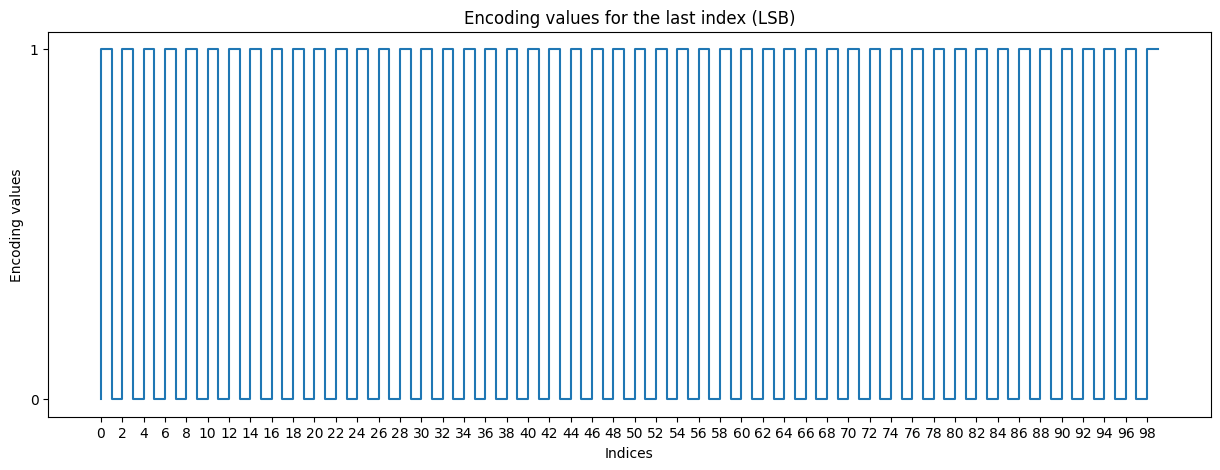

In [7]:
plot_encoding_indices(encodings=binary_encodings, index=-1, enc_type='binary')

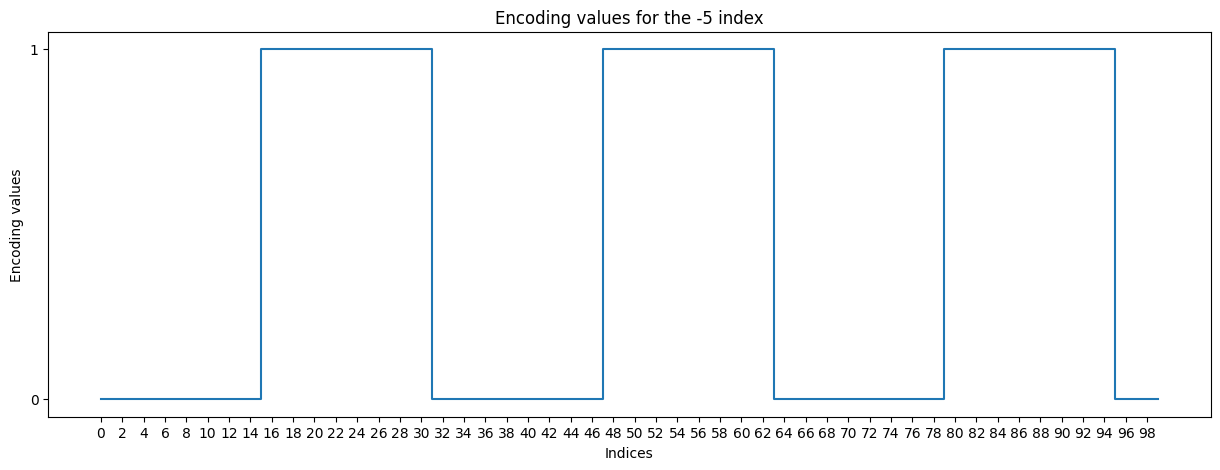

In [8]:
# Plotting for the Least Significant Bit
plot_encoding_indices(encodings=binary_encodings, index=-5, enc_type='binary')

### Sinusoidal Positional Encodings

In [9]:
# Generating sinusoidal encoding
def get_sinusoidal_encodings(position, dmodel):
    embedding = []
    for i in range(dmodel // 2):
        # Getting the frequency (same for both sin and cos)
        pos_freq = position / (10000 ** (2 * i / dmodel))
        # Append sine for dimension 2i
        embedding.append(math.sin(pos_freq))
        # Append cosine for dimension 2i+1
        embedding.append(math.cos(pos_freq))
    return embedding[::-1]

In [10]:
# Checking for a sample input
position, dimension = 5, 10

output = get_sinusoidal_encodings(position, dimension)
assert len(output) == dimension, "Length of the embedding vector should match the embedding dimension"

In [11]:
# Generating encodings for a list of positions
sin_encodings = generate_encodings(100, 200, 'sin') # Generates 100 encodings, each having 100 dimensions

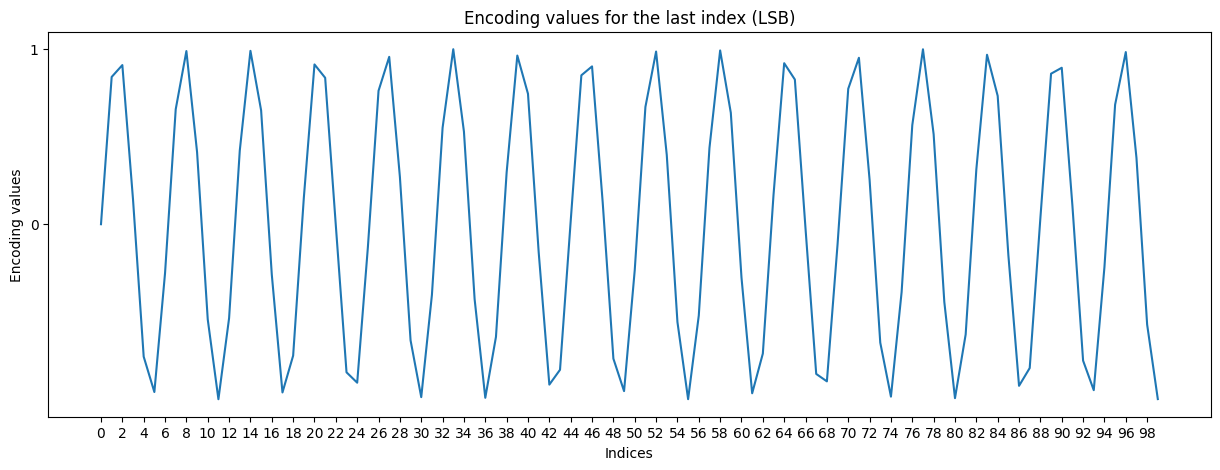

In [12]:
# Plotting for the Least Significant Bit
plot_encoding_indices(encodings=sin_encodings, index=-1, enc_type='sin')

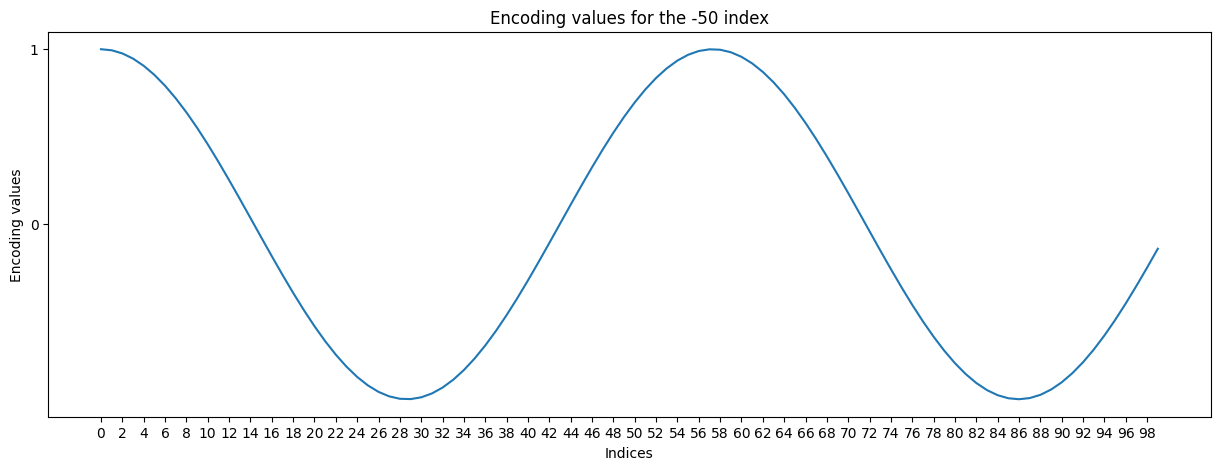

In [13]:
plot_encoding_indices(encodings=sin_encodings, index=-50, enc_type='sin')